In [35]:
# _*_ coding: utf-8 _*_
# @Time: 2021/11/29 24:17 
# @Author: yuyongsheng
# @Software: PyCharm
# @Description: 上海六院甲氨蝶呤：3. 特征工程

In [118]:
# 导入程序包
import pymysql as MySQLDB
import pandas as pd
import numpy as np

import re
import sys
import os
project_path = os.getcwd()

# 特征清洗

In [119]:
df_model=pd.read_excel(project_path+'/data/processed_data/df_11.4_人工删除无意义列.xlsx')
if 'Unnamed: 0' in df_model.columns:
    df_model = df_model.drop(['Unnamed: 0'], axis=1)

In [120]:
df_model[[ 'RBC平均容量', 'RBC平均血红量', 'RBC血红浓度']].corr()


,RBC平均容量,RBC平均血红量,RBC血红浓度
RBC平均容量,1.000000,0.866762,-0.054342
RBC平均血红量,0.866762,1.000000,0.448312
RBC血红浓度,-0.054342,0.448312,1.000000


## 数据转换

In [121]:
df_model['gender'] = df_model['gender'].str.replace(' ','').apply(lambda x: 1 if x == '男' else 0)

## 删除无关特征

In [122]:
df_model.columns

Index(['patient_id', 'case_no', 'drug_name', '日剂量', 'start_datetime',
       'end_datetime', 'gender', 'age', '血红蛋白_before', '血红蛋白_3d', '白细胞_before',
       '白细胞_3d', '粒细胞_before', '血小板_before', '血小板_3d', '血红蛋白_before_B',
       '血红蛋白_3d_B', '白细胞_before_B', '白细胞_3d_B', '粒细胞_before_B', '血小板_before_B',
       '血小板_3d_B', 'bmd_before', 'bmd_3d', 'bmd_7d', 'bmd_14d', 'bmd_time',
       'bmd_label', 'MTX_tdm_24h', 'MTX_tdm_48h', 'MTX_tdm_72h', '吸烟史', '饮酒史',
       '高血压', '糖尿病', '肝炎', '多柔比星', '异环磷酰胺', '顺铂', '依托泊苷', '多柔比星脂质体', '头孢类',
       '促红素', '吡柔吡星', '抗凝血', '谷胱甘肽', '异甘草酸镁', '地塞米松磷酸钠', '托烷司琼', '甘草酸苷',
       '长春新碱', '多烯磷脂酰', '甲氨蝶呤+多柔比星', '甲氨蝶呤+多柔比星脂质体', '甲氨蝶呤+顺铂', '甲氨蝶呤+异环磷酰胺',
       '甲氨蝶呤+依托泊苷', '甲氨蝶呤+多柔比星+顺铂', '甲氨蝶呤+多柔比星+异环磷酰胺', '甲氨蝶呤+多柔比星+依托泊苷',
       '甲氨蝶呤+多柔比星脂质体+顺铂', '甲氨蝶呤+多柔比星脂质体+异环磷酰胺', '甲氨蝶呤+多柔比星脂质体+依托泊苷',
       '甲氨蝶呤+顺铂+异环磷酰胺', '甲氨蝶呤+顺铂+依托泊苷', '甲氨蝶呤+异环磷酰胺+依托泊苷',
       '甲氨蝶呤+多柔比星+顺铂+异环磷酰胺', '甲氨蝶呤+多柔比星+顺铂+依托泊苷', '甲氨蝶呤+多柔比星+异环磷酰胺+依托泊苷',
       '甲氨蝶呤+多柔比星脂质体+顺铂+异环磷酰胺', '甲氨蝶呤+多柔比

In [123]:
# 删除无关特征
df_model=df_model.drop(['patient_id','case_no','drug_name','start_datetime','end_datetime','group','bmd_time'],axis=1)

In [124]:
# 删除目标变强强相关列
del df_model['bmd_before']
del df_model['bmd_3d']
del df_model['bmd_7d']
del df_model['bmd_14d']

df_model=df_model.drop(['血红蛋白_before','血红蛋白_3d','白细胞_before','白细胞_3d','粒细胞_before','血小板_before','血小板_3d',
                '血红蛋白_before_B','血红蛋白_3d_B','白细胞_before_B','白细胞_3d_B','粒细胞_before_B','血小板_before_B','血小板_3d_B'],axis=1)

## 删除缺失超过50%的特征

In [125]:
# 删除缺失超过50%的其他指标
for i in df_model.columns:
    if df_model[i].isnull().sum()/df_model.shape[0] >= 0.5:
        print(i)
        del df_model[i]

In [126]:
print(df_model.shape)  # (106,101)

(718, 75)


In [127]:
# 删除缺失超过50%的特征
writer=pd.ExcelWriter(project_path+'/data/result/feature_engineering/df_1.3_删除缺失超过50%.xlsx')
df_model.to_excel(writer)
writer.save()

## 删除分类极不平衡的特征

In [128]:
# 保护目标变量、tdm数据
for i in df_model.columns[8:]:
    if df_model[i].nunique() < 2:
        del df_model[i]
        continue
    if df_model[i].nunique() == 2:
        # 如果分类变量中某一变量的占比超过90%，则删除该指标
        num_1 = df_model[i].value_counts()  # df一列中不同变量的数目
        num_2 = num_1.div(df_model.shape[0])  # div除法，所有元素都除以相同数值
        num_3 = num_2.max()  # 取出最大值
        if num_3 >= 0.9:
            print(i)
            del df_model[i]

饮酒史
高血压
糖尿病
肝炎
异环磷酰胺
顺铂
头孢类
促红素
抗凝血
地塞米松磷酸钠
甲氨蝶呤+顺铂
甲氨蝶呤+异环磷酰胺


In [129]:
print(df_model.shape) 

(718, 38)


In [130]:
# 删除缺失超过50%的特征
writer=pd.ExcelWriter(project_path+'/data/result/feature_engineering/df_1.4_删除分类极不平衡.xlsx')
df_model.to_excel(writer)
writer.save()

## 过滤异常值

In [131]:
# 过滤异常值，大于正常值超过100倍！
for i in df_model.columns[8:]:
    # 测试特征是否存在异常值
    median_value= max(df_model[i].median(),1)
    max_value = df_model[i].max()
    if max_value > 100 * median_value:
        print(i)
    df_model[i]=df_model[i].apply(lambda x: np.nan if x<0 or x!=x else 100*median_value if float(x) > 100*median_value else x)

红细胞


In [132]:
print(df_model.shape)  

(718, 38)


In [133]:
df_model.columns

Index(['日剂量', 'gender', 'age', 'bmd_label', 'MTX_tdm_24h', 'MTX_tdm_48h',
       'MTX_tdm_72h', '吸烟史', '谷胱甘肽', '异甘草酸镁', '托烷司琼', '甘草酸苷', '长春新碱', '多烯磷脂酰',
       'RBC平均容量', 'RBC平均血红量', 'RBC血红浓度', 'γ-谷氨酰酶(干式)', '中性细胞百分比', '中性细胞绝对值',
       '乳酸脱氢酶(干式)', '单核细胞百分比', '单核细胞绝对值', '嗜碱性细胞百分比', '嗜碱性细胞绝对值', '嗜酸性细胞百分比',
       '嗜酸性细胞绝对值', '总胆红素(干式)', '总蛋白(干式)', '淋巴细胞百分比', '淋巴细胞绝对值', '白蛋白(干式)',
       '碱性磷酸酶(干式)', '红细胞', '红细胞分布宽度', '肌酐(干式)', '谷丙转氨酶(干式)', '谷草转氨酶(干式)'],
      dtype='object')

In [134]:
# 保存特征清洗
writer = pd.ExcelWriter(project_path + '/data/result/feature_engineering/df_1_特征清洗.xlsx')
df_model.to_excel(writer)
writer.save()

# 显著性分析

In [135]:
discrete_col=['gender','吸烟史','谷胱甘肽','异甘草酸镁','托烷司琼','甘草酸苷','长春新碱','多烯磷脂酰']
continuous_col=[x for x in df_model.columns if x not in discrete_col]
continuous_col.remove('bmd_label')

## 分类变量显著性分析

In [136]:
# 二分类卡方检验
from scipy.stats import chi2_contingency
feature_list=[]
y_list=[]
t_list=[]
p_list=[]
sig_list=[]
for i in discrete_col:
    print(i)
    result = chi2_contingency(pd.crosstab(df_model['bmd_label'],df_model[i]))
    t,p=result[0:2]
    t=round(t,2)
    p=round(p,3)
    feature_list.append(i)
    y_list.append('卡方检验')
    t_list.append(t)
    p_list.append(p)
    if p <=0.05:
        sig='显著'
    else:
        sig='不显著'
    sig_list.append(sig)

gender
吸烟史
谷胱甘肽
异甘草酸镁
托烷司琼
甘草酸苷
长春新碱
多烯磷脂酰


In [137]:
df_result_dis=pd.DataFrame({'特征':feature_list,
                        '检验指标':y_list,
                        't值':t_list,
                        'p值':p_list,
                        '显著性结果':sig_list})

In [138]:
# psm分类变量显著性检验
writer=pd.ExcelWriter(project_path+'/data/result/feature_engineering/df_2.1_分类变量显著性检验.xlsx')
df_result_dis.to_excel(writer)
writer.save()

In [139]:
len(feature_list)

8

## 连续变量显著性分析

In [140]:
from scipy.stats import kstest,shapiro
##检验是否正态
def norm_test(data):
    if len(data) > 30:
        norm, p = kstest(data, 'norm')
    else:
        norm, p = shapiro(data)
    #print(t,p)
    if p>=0.05:
        return True
    else:
        return False

In [141]:
import scipy.stats as st
# 连续变量的显著性检验
def test2(data_b, data_p):
    if norm_test(data_b) and norm_test(data_p):
        x = 1
        y = '独立样本T检验'
        t, p = st.ttest_ind(list(data_b),list(data_p), nan_policy='omit')
    else:
        x = 0
        y = 'Mann-Whitney U检验'
        t,p = st.mannwhitneyu(list(data_b),list(data_p))
    return x,y,t,p

In [142]:
def sig_test(df_high,df_low,list1):

    feature_list=[]  # 特征列表
    y_list=[]  # 显著性检验方法
    t_list=[]  # 统计量
    p_list=[]  # p值
    result_list=[]  # 是否显著
    high_mean_list=[]
    low_mean_list=[]

    for i in list1:
        print(i)
        # 高剂量组统计
        df_high_nt=df_high[df_high[i].notnull()]
        data_high=df_high_nt[i]
        high_mean=round(data_high.mean(),2)
        
        df_low_nt=df_low[df_low[i].notnull()]
        data_low=df_low_nt[i]
        low_mean=round(data_low.mean(),2)

        # 计算高低剂量组显著性差异
        if data_high.shape[0] >= 10 and data_low.shape[0]>=10:
            # 连续变量检验
            x,y,t,p = test2(data_high, data_low)
            t=round(t,2)
            p=round(p,3)
            if p <=0.05:
                sig='显著'
            else:
                sig='不显著'
            # 显著性 
            feature_list.append(i)
            y_list.append(y)
            t_list.append(t)
            p_list.append(p)
            result_list.append(sig)
            high_mean_list.append(high_mean)
            low_mean_list.append(low_mean)

    df_result=pd.DataFrame({'特征':feature_list,
                            '高剂量均值':high_mean_list,
                            '低剂量均值':low_mean_list,
                            '检验指标':y_list,
                            't值':t_list,
                            'p值':p_list,
                            '显著性结果':result_list})
    return df_result

In [143]:
# 提取甲氨蝶呤不同标签
df_MTX_high = df_model[df_model['bmd_label']==1]
df_MTX_low = df_model[df_model['bmd_label']==0]

In [144]:
# 甲氨蝶呤高低剂量组PSM控制变量统计和显著性检验
df_MTX_PSM_sig = sig_test(df_MTX_high,df_MTX_low,continuous_col)
df_MTX_PSM_sig = df_MTX_PSM_sig.reset_index(drop=True)

日剂量
age
MTX_tdm_24h
MTX_tdm_48h
MTX_tdm_72h
RBC平均容量
RBC平均血红量
RBC血红浓度
γ-谷氨酰酶(干式)
中性细胞百分比
中性细胞绝对值
乳酸脱氢酶(干式)
单核细胞百分比
单核细胞绝对值
嗜碱性细胞百分比
嗜碱性细胞绝对值
嗜酸性细胞百分比
嗜酸性细胞绝对值
总胆红素(干式)
总蛋白(干式)
淋巴细胞百分比
淋巴细胞绝对值
白蛋白(干式)
碱性磷酸酶(干式)
红细胞
红细胞分布宽度
肌酐(干式)
谷丙转氨酶(干式)
谷草转氨酶(干式)


In [145]:
# 保存高低剂量组PSM控制变量统计和显著性检验
writer=pd.ExcelWriter(project_path+r'/data/result/feature_engineering/df_2.2_连续变量相关性分析.xlsx')
df_MTX_PSM_sig.to_excel(writer)
writer.save()

In [146]:
continuous_relate = list(df_MTX_PSM_sig[df_MTX_PSM_sig['显著性结果']=='显著']['特征'])

In [147]:
list(df_MTX_PSM_sig[df_MTX_PSM_sig['显著性结果']=='不显著']['特征'])

['日剂量',
 'age',
 'MTX_tdm_24h',
 'MTX_tdm_48h',
 'MTX_tdm_72h',
 'RBC平均容量',
 'RBC平均血红量',
 'RBC血红浓度',
 'γ-谷氨酰酶(干式)',
 '嗜碱性细胞绝对值',
 '总胆红素(干式)',
 '碱性磷酸酶(干式)',
 '红细胞分布宽度',
 '谷丙转氨酶(干式)']

In [148]:
# 业务角度需要保留：日剂量、age、MTX_tdm_24h、MTX_tdm_48h、MTX_tdm_72h
continuous_relate.extend(['日剂量','age','MTX_tdm_24h','MTX_tdm_48h','MTX_tdm_72h','RBC平均容量','RBC血红浓度'])

In [149]:
len(continuous_relate)

22

In [150]:
# 提取相关性特征
feature_relate=discrete_col + continuous_relate
# 加入目标变量
feature_relate.insert(0,'bmd_label')
df_model_relate=df_model[feature_relate]

In [151]:
# 保存显著性分析结果
writer = pd.ExcelWriter(project_path + '/data/result/feature_engineering/df_2_显著性清洗.xlsx')
df_model_relate.to_excel(writer)
writer.save()

# 重要性评分排序

In [152]:
df_model_relate.shape

(718, 31)

In [153]:
from sklearn.model_selection import train_test_split

# 划分训练集和测试集，比例为8:2
x = df_model_relate.drop(['bmd_label'],axis=1)
y = df_model_relate['bmd_label']
tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=5)

In [154]:
# 重要性
import catboost,xgboost
model_boost=xgboost.XGBClassifier(max_depth=5,
                                learning_rate=0.01,
                                n_estimators=500,
                                min_child_weight=0.5,
                                eta=0.1,
                                gamma=0.5,
                                reg_lambda=10,
                                subsample=0.5,
                                colsample_bytree=0.8,
                                nthread=4,
                                scale_pos_weight=1)
model_boost.fit(tran_x,tran_y)
importance = model_boost.feature_importances_
print(tran_x.columns)
print(importance)

Index(['gender', '吸烟史', '谷胱甘肽', '异甘草酸镁', '托烷司琼', '甘草酸苷', '长春新碱', '多烯磷脂酰',
       '中性细胞百分比', '中性细胞绝对值', '乳酸脱氢酶(干式)', '单核细胞百分比', '单核细胞绝对值', '嗜碱性细胞百分比',
       '嗜酸性细胞百分比', '嗜酸性细胞绝对值', '总蛋白(干式)', '淋巴细胞百分比', '淋巴细胞绝对值', '白蛋白(干式)',
       '红细胞', '肌酐(干式)', '谷草转氨酶(干式)', '日剂量', 'age', 'MTX_tdm_24h',
       'MTX_tdm_48h', 'MTX_tdm_72h', 'RBC平均容量', 'RBC血红浓度'],
      dtype='object')
[0.02638529 0.02128197 0.03516589 0.06287862 0.04152709 0.0597481
 0.01910781 0.02832386 0.02174501 0.03712744 0.04362798 0.05029701
 0.08309329 0.02761939 0.02926641 0.03542112 0.02103227 0.04486332
 0.02064868 0.02253822 0.03077013 0.02133169 0.06081294 0.01862139
 0.0263206  0.01998792 0.02240159 0.02419785 0.02488325 0.01897374]


In [155]:
df_importance= pd.DataFrame(data={'特征':tran_x.columns,'重要性评分':importance})
df_importance['重要性评分']=df_importance['重要性评分'].apply(lambda x: round(x,3))
df_importance=df_importance.sort_values(['重要性评分'],ascending=False)
df_importance=df_importance.reset_index(drop=True)

In [156]:
df_importance.to_excel(project_path + '/data/result/feature_engineering/df_3_模型重要性评分.xlsx')

In [157]:
# 筛选重要特征组建建模数据
df_importance_select=df_importance[df_importance['重要性评分']>0]
select_list = list(df_importance_select['特征'])
select_list.insert(0,'bmd_label')

In [158]:
df_model_importance = df_model_relate[select_list]

In [159]:
df_model_importance.shape

(718, 31)

In [160]:
# 保存重要性评分筛选后的建模数据
writer = pd.ExcelWriter(project_path + '/data/result/df_model_data_importance.xlsx')
df_model_importance.to_excel(writer)
writer.save()

# 逐步向前

In [161]:
df_model_importance

,bmd_label,单核细胞绝对值,异甘草酸镁,谷草转氨酶(干式),甘草酸苷,单核细胞百分比,淋巴细胞百分比,乳酸脱氢酶(干式),托烷司琼,中性细胞绝对值,...,中性细胞百分比,MTX_tdm_48h,总蛋白(干式),淋巴细胞绝对值,吸烟史,肌酐(干式),MTX_tdm_24h,日剂量,长春新碱,RBC血红浓度
0,0,0.1,1,45.0,0,3.0,20.9,471.0,1,3.5,...,75.0,3.48,64.0,1.0,0.0,62.0,28.32,20.0,0,334.0
1,0,0.1,1,46.0,0,3.0,22.4,511.0,0,2.9,...,73.8,0.10,64.0,0.9,0.0,35.0,6.90,11.0,0,356.0
2,1,0.5,0,69.0,0,3.9,5.7,717.0,0,10.6,...,89.8,4.85,66.0,0.7,0.0,57.0,14.83,21.0,0,339.0
3,1,0.2,0,86.0,0,4.2,16.4,491.0,0,2.9,...,78.4,3.79,62.0,0.6,0.0,39.0,9.21,13.0,0,338.0
4,0,0.2,0,33.0,1,5.6,7.0,381.0,0,3.1,...,86.8,3.74,63.0,0.3,0.0,61.0,57.57,16.0,0,345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0,0.2,1,18.0,0,1.7,8.0,788.0,0,11.0,...,90.3,0.10,71.0,1.0,0.0,49.0,0.90,18.0,0,341.0
714,1,0.4,1,16.0,0,15.1,18.7,388.0,1,1.6,...,62.8,1.13,59.0,0.5,0.0,66.0,14.30,16.5,0,331.0
715,0,0.1,1,83.0,0,3.1,40.1,605.0,1,1.7,...,53.7,0.10,65.0,1.3,0.0,42.0,5.66,12.4,0,345.0
716,0,0.1,0,20.0,0,0.6,8.3,559.0,0,7.1,...,89.0,NaN,60.0,0.7,0.0,33.0,0.10,16.0,0,326.0


## 插补数据

In [162]:
# 使用随机森林对缺失值进行插补
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def missing_value_interpolation(df):
    df = df.reset_index(drop=True)
    # 提取存在缺失值的列名
    missing_list = []
    for i in df.columns:
        if df[i].isnull().sum() > 0:
            missing_list.append(i)
    missing_list_copy = missing_list.copy()
    # 用该列未缺失的值训练随机森林，然后用训练好的rf预测缺失值
    for i in range(len(missing_list)):
        name=missing_list[0]
        df_missing = df[missing_list_copy]
        # 将其他列的缺失值用0表示。
        missing_list.remove(name)
        for j in missing_list:
            df_missing[j]=df_missing[j].astype('str').apply(lambda x: 0 if x=='nan' else x)
        df_missing_is = df_missing[df_missing[name].isnull()]
        df_missing_not = df_missing[df_missing[name].notnull()]
        y = df_missing_not[name]
        x = df_missing_not.drop([name],axis=1)
        # 列出参数列表
        tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
        # 进行参数的搜索组合
        grid = GridSearchCV(RandomForestRegressor(),param_grid=tree_grid_parameter,cv=3)
        #rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
        #根据已有数据去拟合随机森林模型
        grid.fit(x, y)
        rfr = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'])
        rfr.fit(x, y)
        #预测缺失值
        predict = rfr.predict(df_missing_is.drop([name],axis=1))
        #填补缺失值
        df.loc[df[name].isnull(),name] = predict
    return df

In [163]:
df_model_cb=missing_value_interpolation(df_model_importance)

In [164]:
df_model_cb.shape

(718, 31)

## 划分数据集和过采样

In [165]:
from sklearn.model_selection import train_test_split
# 划分训练集和测试集，比例为8:2
x = df_model_cb.drop(['bmd_label'],axis=1)
y = df_model_cb['bmd_label']

tran_x, test_x, tran_y, test_y = train_test_split(x, y, test_size=0.2, random_state=5)

In [166]:
tran_x.shape

(574, 30)

In [167]:
# 进行过采样
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)

tran_x_sm,tran_y_sm = sm.fit_resample(tran_x,tran_y)

In [168]:
tran_x_sm.shape[1]

30

##  forward stepwise

In [196]:
tran_x_sm.columns

Index(['单核细胞绝对值', '异甘草酸镁', '谷草转氨酶(干式)', '甘草酸苷', '单核细胞百分比', '淋巴细胞百分比',
       '乳酸脱氢酶(干式)', '托烷司琼', '中性细胞绝对值', '嗜酸性细胞绝对值', '谷胱甘肽', '红细胞', '嗜酸性细胞百分比',
       '多烯磷脂酰', '嗜碱性细胞百分比', 'age', 'gender', 'RBC平均容量', 'MTX_tdm_72h',
       '白蛋白(干式)', '中性细胞百分比', 'MTX_tdm_48h', '总蛋白(干式)', '淋巴细胞绝对值', '吸烟史',
       '肌酐(干式)', 'MTX_tdm_24h', '日剂量', '长春新碱', 'RBC血红浓度'],
      dtype='object')

In [231]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier

r2_max_list=[]
feature_max_list=[]
for i in range(1,tran_x_sm.shape[1]+1):
    # 津源xgboost模型
    sfs = SFS(RandomForestClassifier(n_estimators=500,
                                    criterion='entropy',
                                    max_depth=5,
                                    n_jobs=-1,
                                    random_state=3),
              n_jobs=-1, # 并行使用的进程数，默认1个，如果设置为-1，该值为总的核数
              k_features=i,
             forward=True,
             floating=False,  
             verbose=2,  # 显示输出的一些参数，默认为0不输出
             scoring='f1',  # 'f1' for binary targets
             cv=3)  # cv交叉验证

    sfs = sfs.fit(tran_x_sm, tran_y_sm)
    # 逐步向前筛选结果，包括特征个数，最优特征组合及其r2
    sfs_result = sfs.subsets_
    df_sfs = pd.DataFrame(sfs_result)
    # 逐步向前结果
    r2_list=list(df_sfs.loc['avg_score'])
    feature_list=list(df_sfs.loc['feature_names'])
    # 保存特征组合
    r2_max_list.append(r2_list[-1])
    feature_max_list.append(feature_list[-1])
#     if i==4:
#         break

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.1s finished

[2021-12-13 20:41:11] Features: 1/1 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.5s finished

[2021-12-13 20:41:29] Features: 1/2 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.9s finished

[2021-12-13 20:41:49] Features: 2/2 -- score: 0.9147936008521561[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.2s finished

[2021-12-13 20:42:10] Features: 1/3 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent work

[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.2s finished

[2021-12-13 20:51:32] Features: 6/8 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   15.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.6s finished

[2021-12-13 20:51:48] Features: 7/8 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:   14.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   15.0s finished

[2021-12-13 20:52:03] Features: 8/8 -- score: 0.972756981580511[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.1s finished

[2021-12-13 20:52:22] Features: 1/9 -- score: 0.90

[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:   13.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   14.4s finished

[2021-12-13 21:00:43] Features: 10/11 -- score: 0.9728267578217727[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   10.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.9s finished

[2021-12-13 21:00:57] Features: 11/11 -- score: 0.9737230302886027[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.9s finished

[2021-12-13 21:01:16] Features: 1/12 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.7s finished

[2021-12-13 21:01:35] Features: 2/12 -- scor

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   17.6s finished

[2021-12-13 21:08:55] Features: 4/14 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.5s finished

[2021-12-13 21:09:13] Features: 5/14 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.4s finished

[2021-12-13 21:09:30] Features: 6/14 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   14.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.3s finished

[2021-12-13 21:09:46] Features: 7/14 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.5s finished

[2021-12-13 21:16:57] Features: 5/16 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.8s finished

[2021-12-13 21:17:14] Features: 6/16 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   15.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.2s finished

[2021-12-13 21:17:29] Features: 7/16 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:   14.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   14.5s finished

[2021-12-13 21:17:44] Features: 8/16 -- score:

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.1s finished

[2021-12-13 21:24:04] Features: 1/18 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   18.9s finished

[2021-12-13 21:24:23] Features: 2/18 -- score: 0.9147936008521561[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.2s finished

[2021-12-13 21:24:41] Features: 3/18 -- score: 0.9213310133619812[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   17.9s finished

[2021-12-13 21:24:59] Features: 4/18 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   10.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.7s finished

[2021-12-13 21:31:40] Features: 13/19 -- score: 0.9726330532212885[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    9.8s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   12.7s finished

[2021-12-13 21:31:53] Features: 14/19 -- score: 0.9727135027879908[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    9.6s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   10.6s finished

[2021-12-13 21:32:04] Features: 15/19 -- score: 0.9727992865386632[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    6.0s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  15 ou

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.2s finished

[2021-12-13 21:38:23] Features: 3/21 -- score: 0.9213310133619812[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.2s finished

[2021-12-13 21:38:41] Features: 4/21 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.9s finished

[2021-12-13 21:38:59] Features: 5/21 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.3s finished

[2021-12-13 21:39:17] Features: 6/21 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:   11.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.2s finished

[2021-12-13 21:45:25] Features: 11/22 -- score: 0.9737230302886027[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:   10.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   13.5s finished

[2021-12-13 21:45:39] Features: 12/22 -- score: 0.9718970005065356[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   10.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.9s finished

[2021-12-13 21:45:52] Features: 13/22 -- score: 0.9726330532212885[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    9.9s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  17 ou

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   10.7s finished

[2021-12-13 21:51:40] Features: 17/23 -- score: 0.9727992865386632[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    5.4s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   10.0s finished

[2021-12-13 21:51:50] Features: 18/23 -- score: 0.972883616514773[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.9s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.2s finished

[2021-12-13 21:51:59] Features: 19/23 -- score: 0.9755693267738845[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    4.8s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    6.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  11 out

[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.1s finished

[2021-12-13 21:57:33] Features: 22/24 -- score: 0.9746340365800199[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.7s finished

[2021-12-13 21:57:39] Features: 23/24 -- score: 0.9728299802157658[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    4.6s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.3s finished

[2021-12-13 21:57:44] Features: 24/24 -- score: 0.9728356658672329[Parallel(n_jobs=-1)]: Using 

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.7s finished

[2021-12-13 22:03:02] Features: 25/25 -- score: 0.9736692062034248[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.1s finished

[2021-12-13 22:03:21] Features: 1/26 -- score: 0.9016914032231247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.0s finished

[2021-12-13 22:03:40] Features: 2/26 -- score: 0.9147936008521561[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.4s finished

[2021-12-13 22:03:58] Features: 3/26 -- score: 0.9213310133619812[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concu

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   18.1s finished

[2021-12-13 22:09:22] Features: 3/27 -- score: 0.9213310133619812[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.2s finished

[2021-12-13 22:09:40] Features: 4/27 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.6s finished

[2021-12-13 22:09:58] Features: 5/27 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.5s finished

[2021-12-13 22:10:15] Features: 6/27 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.3s finished

[2021-12-13 22:15:06] Features: 4/28 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   18.1s finished

[2021-12-13 22:15:24] Features: 5/28 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.4s finished

[2021-12-13 22:15:41] Features: 6/28 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   15.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.7s finished

[2021-12-13 22:15:57] Features: 7/28 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.1s finished

[2021-12-13 22:20:36] Features: 4/29 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.8s finished

[2021-12-13 22:20:54] Features: 5/29 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.4s finished

[2021-12-13 22:21:11] Features: 6/29 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   15.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   16.0s finished

[2021-12-13 22:21:27] Features: 7/29 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   18.3s finished

[2021-12-13 22:26:08] Features: 4/30 -- score: 0.9391060061322003[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.7s finished

[2021-12-13 22:26:26] Features: 5/30 -- score: 0.9517279412721081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.4s finished

[2021-12-13 22:26:43] Features: 6/30 -- score: 0.9631056065849685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:   15.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.5s finished

[2021-12-13 22:26:59] Features: 7/30 -- score: 0.9672826186459519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concur

In [236]:
r2_list[-1]

0.9684019660794503

In [237]:
df_forward_result=pd.DataFrame(data={'r2':r2_max_list,
                                    'feature_names':feature_max_list})

In [238]:
df_forward_result

,r2,feature_names
0,0.901691,"(单核细胞绝对值,)"
1,0.914794,"(单核细胞绝对值, 异甘草酸镁)"
2,0.921331,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷)"
3,0.939106,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, MTX_tdm_72h)"
4,0.951728,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, MTX_tdm_72h)"
5,0.963106,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 嗜碱性细胞百分比, MTX_tdm..."
6,0.967283,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, M..."
7,0.972757,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."
8,0.971001,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."
9,0.972827,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."


In [239]:
# 保存模型测试和测试结果到本地文件
writer = pd.ExcelWriter(project_path + '/data/result/feature_engineering/df_4_逐步向前特征测试结果.xlsx')
df_forward_result.to_excel(writer)
writer.save()

In [240]:
df_forward_result

,r2,feature_names
0,0.901691,"(单核细胞绝对值,)"
1,0.914794,"(单核细胞绝对值, 异甘草酸镁)"
2,0.921331,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷)"
3,0.939106,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, MTX_tdm_72h)"
4,0.951728,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, MTX_tdm_72h)"
5,0.963106,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 嗜碱性细胞百分比, MTX_tdm..."
6,0.967283,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, M..."
7,0.972757,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."
8,0.971001,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."
9,0.972827,"(单核细胞绝对值, 异甘草酸镁, 甘草酸苷, 托烷司琼, 谷胱甘肽, 嗜碱性细胞百分比, g..."


## 逐步向前绘图

In [245]:
df_forward_result =pd.read_excel(project_path +'/data/result/feature_engineering/df_4_逐步向前特征测试结果.xlsx')
if 'Unnamed: 0' in df_forward_result.columns:
    df_forward_result = df_forward_result.drop(['Unnamed: 0'], axis=1)

In [246]:
# 计算R2和MSE、RMSE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,roc_auc_score,f1_score
# XGBoost模型
feature_col_list=[]
f1_list=[]
for i in range(df_forward_result.shape[0]):
    feature_list=str(df_forward_result.loc[i,'feature_names']).split('\'')
    feature_list=feature_list[1:-1:2]

    tran_x_select=tran_x_sm[feature_list]
    test_x_select=test_x[feature_list]
    # 列出参数列表
    tree_grid_parameter = {'n_estimators': list((10, 50, 100, 150, 200))}
    # 进行参数的搜索组合
    grid = GridSearchCV(RandomForestClassifier(),param_grid=tree_grid_parameter,cv=3)
    #rfr=RandomForestRegressor(random_state=0,n_estimators=100,n_jobs=-1)
    #根据已有数据去拟合随机森林模型
    grid.fit(tran_x_select, tran_y_sm)
    rfr = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'])
    rfr.fit(tran_x_select, tran_y_sm)
    predictions=rfr.predict(test_x_select)

    # 检验指标
    f1 = roc_auc_score(test_y,predictions)
    feature_col_list.append(feature_list)
    f1_list.append(f1)
    print('f1: ',f1)

f1:  0.6313186813186812
f1:  0.6747252747252748
f1:  0.6989010989010989
f1:  0.723076923076923
f1:  0.6873626373626374
f1:  0.7549450549450549
f1:  0.8494505494505495
f1:  0.8137362637362637
f1:  0.8137362637362637
f1:  0.8137362637362637
f1:  0.8137362637362637
f1:  0.8137362637362637
f1:  0.8532967032967034
f1:  0.8137362637362637
f1:  0.8137362637362637
f1:  0.8175824175824176
f1:  0.7818681318681319
f1:  0.7818681318681319
f1:  0.7818681318681319
f1:  0.7818681318681319
f1:  0.778021978021978
f1:  0.6747252747252748
f1:  0.8137362637362637
f1:  0.7818681318681319
f1:  0.8175824175824176
f1:  0.8532967032967034
f1:  0.8175824175824176
f1:  0.8175824175824176
f1:  0.8175824175824176
f1:  0.7818681318681319


In [247]:
df_f1=pd.DataFrame(data={'feature_list':feature_col_list,
                        'f1':f1_list})
df_f1.to_excel(project_path+'/f1.xlsx')

Text(0, 0.5, 'AUC')

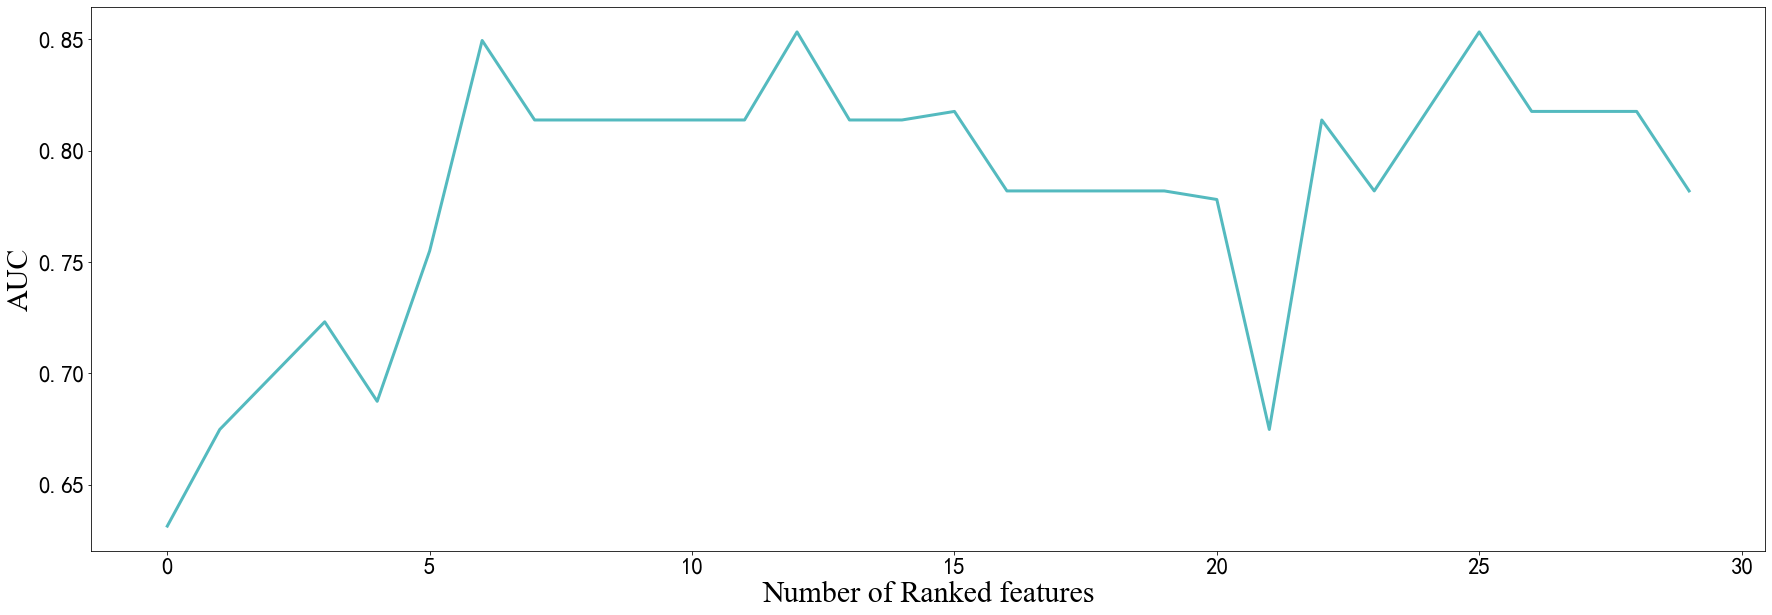

In [248]:
# 画图
import matplotlib.pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']  ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

# r2折线图
# 分辨率参数-dpi，画布大小参数-figsize
plt.figure(figsize=(30,10))
plt.plot(list(range(len(f1_list))),f1_list,
         color=(0.32941176470588235, 0.7294117647058823, 0.7490196078431373), label='AUC',linewidth=3) # 线粗细
# 设置坐标刻度值的大小
plt.tick_params(labelsize=23)

# 设置横纵坐标的名称以及对应字体格式
font_x = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 30,
         }
plt.xlabel('Number of Ranked features',font_x)
plt.ylabel('AUC',font_x)

# 展示横坐标
# x_list=list(df_feature['特征'])
# plt.xticks(list(range(len(f1_list))),f1_list,rotation=285)
# plt.legend(bbox_to_anchor=(1.1,1))  # 显示图例

In [249]:
# 判断图片保存路径是否存在，否则创建
jpg_path = project_path + "/jpg"
mkdir(jpg_path)
plt.savefig(jpg_path + "/逐步向前rf_model2折线图.png", dpi=300)
plt.clf()  # 删除前面所画的图roc_auc_scoreroc_auc_scoreroc_auc_scoreroc_auc_score

NameError: name 'mkdir' is not defined

## 保存逐步向前筛选的建模数据

In [252]:
f1_max_index=f1_list.index(max(f1_list))
print(f1_max_index)
feature_com_best=df_forward_result.loc[f1_max_index,'feature_names']
print(feature_com_best)

12
('单核细胞绝对值', '异甘草酸镁', '甘草酸苷', '托烷司琼', '谷胱甘肽', '嗜酸性细胞百分比', '多烯磷脂酰', '嗜碱性细胞百分比', 'gender', 'RBC平均容量', 'MTX_tdm_72h', '白蛋白(干式)', 'MTX_tdm_48h')


In [253]:
feature_list=str(feature_com_best).split('\'')
feature_forward_select=feature_list[1:-1:2]
# feature_forward_select=['单核细胞绝对值','异甘草酸镁','甘草酸苷','托烷司琼','谷胱甘肽','红细胞','嗜酸性细胞百分比','多烯磷脂酰',
#                         '嗜碱性细胞百分比','gender','RBC平均容量','MTX_tdm_72h','白蛋白(干式)','中性细胞百分比','MTX_tdm_48h',
#                         '长春新碱','RBC血红浓度']
feature_forward_select.insert(0,'bmd_label')

In [254]:
feature_forward_select

['bmd_label',
 '单核细胞绝对值',
 '异甘草酸镁',
 '甘草酸苷',
 '托烷司琼',
 '谷胱甘肽',
 '嗜酸性细胞百分比',
 '多烯磷脂酰',
 '嗜碱性细胞百分比',
 'gender',
 'RBC平均容量',
 'MTX_tdm_72h',
 '白蛋白(干式)',
 'MTX_tdm_48h']

In [255]:
df_model_forward=df_model_importance[feature_forward_select]
df_model_forward.to_excel(project_path+'/data/result/df_model_data_forward.xlsx')